## Assignemnt 1

In [5]:
import pandas as pd

def load_data():
    # Load the data, skipping initial rows that might contain the disclaimer
    data=pd.read_csv('/Users/macbookair/Desktop/ECESIS Investment - 2024 Summer Internship Program/EGPS_PowerCalendar.csv', skiprows=1)   
    # Convert 'StartDate' and 'EndDate' to datetime
    data['StartDate'] = pd.to_datetime(data['StartDate'])
    data['EndDate'] = pd.to_datetime(data['EndDate'])
    return data

def get_hours(iso, peak_type, period):
    data = load_data()
    
    num_hours=0

# Parsing the period input to match data format
    if "Q" in period:
        year, quarter = period[:4], period[-1]
        period_filter = (data['Year'].astype(str) == year) & (data['Quarter'].astype(str) == quarter)
    elif "A" in period:
        year = period.rstrip('A')
        period_filter = data['Year'].astype(str) == year
    elif "-" in period:
        date = pd.to_datetime(period).date()
        period_filter = (data['StartDate'] <= date) & (data['EndDate'] >= date)
    else:
        year, month = period[:4], period[-3:]
        start_date = pd.to_datetime(f"{year}-{month}-01")
        end_date = start_date + pd.offsets.MonthEnd(1)
        period_filter = (data['StartDate'] <= start_date) & (data['EndDate'] >= end_date)

    # Filter the data
    filtered_data = data[(data['Region'].str.contains(iso, case=False)) & (period_filter)]

    # Select the peak type column and sum the hours
    if peak_type.lower() in ['peak', 'offpeak', 'flat', '1x16h'] and not filtered_data.empty:
        num_hours = filtered_data[peak_type.capitalize()].sum()  # Adjust the column name if necessary

    return {
        'iso': iso,
        'peak_type': peak_type,
        'startdate': filtered_data['StartDate'].min().strftime('%Y-%m-%d') if not filtered_data.empty else 'N/A',
        'enddate': filtered_data['EndDate'].max().strftime('%Y-%m-%d') if not filtered_data.empty else 'N/A',
        'num_hours': num_hours
    }

print(get_hours('ERCOT', 'Peak', '2024May'))

{'iso': 'ERCOT', 'peak_type': 'Peak', 'startdate': '2024-05-01', 'enddate': '2024-05-31', 'num_hours': 352}


## Assignment 2

In [6]:
import pandas as pd

# Load the datasets
base_file_path = '/Users/macbookair/Desktop/ECESIS Investment - 2024 Summer Internship Program/Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv'
appliance_file_path = '/Users/macbookair/Desktop/ECESIS Investment - 2024 Summer Internship Program/Assignment 2 - new.app4.csv'

# Read the base file
base_df = pd.read_csv(base_file_path)

# Read the appliance file
appliance_df = pd.read_csv(appliance_file_path)

# Strip extra spaces from the Date/Time column
base_df['Date/Time'] = base_df['Date/Time'].str.strip().str.replace(' 24:00:00', ' 00:00:00')
base_df['Date/Time'] = pd.to_datetime(base_df['Date/Time'], format='%m/%d %H:%M:%S', errors='coerce')

# Increment the date for '00:00:00' times
base_df.loc[base_df['Date/Time'].dt.hour == 0, 'Date/Time'] += pd.Timedelta(days=1)

# Extract Date and Hour
base_df['Date'] = base_df['Date/Time'].dt.strftime('%m-%d')
base_df['Year'] = 2013  # Assuming the appliance data is from 2013
base_df['Date'] = pd.to_datetime(base_df['Year'].astype(str) + '-' + base_df['Date'], format='%Y-%m-%d')
base_df['Hour'] = base_df['Date/Time'].dt.hour

# Clean and prepare the appliance dataframe
appliance_df['time'] = pd.to_datetime(appliance_df['time'])
appliance_df['Date'] = appliance_df['time'].dt.strftime('%m-%d')
appliance_df['Year'] = 2013
appliance_df['Date'] = pd.to_datetime(appliance_df['Year'].astype(str) + '-' + appliance_df['Date'], format='%Y-%m-%d')
appliance_df['Hour'] = appliance_df['time'].dt.hour

# Aggregate the appliance data to hourly by summing up the power consumption in watts and converting to kilowatts
appliance_hourly_df = appliance_df.groupby(['Date', 'Hour']).agg({'W_min': 'sum'}).reset_index()
appliance_hourly_df['new_Electricity_kW'] = appliance_hourly_df['W_min'] / 1000

# Perform a full outer join to include all dates and hours
merged_df = pd.merge(base_df, appliance_hourly_df[['Date', 'Hour', 'new_Electricity_kW']], on=['Date', 'Hour'], how='outer')

# Fill missing values with zeros
merged_df = merged_df.fillna(0)

# Calculate the total hourly consumption
electricity_columns = [col for col in merged_df.columns if 'Electricity' in col and '[kW](Hourly)' in col]
merged_df['Total_Hourly_Consumption_kW'] = merged_df[electricity_columns + ['new_Electricity_kW']].sum(axis=1)

# Select all relevant columns for the final output
final_columns = ['Date/Time'] + [col for col in merged_df.columns if 'kW' in col]
final_df = merged_df[final_columns]

# Display the final dataframe
print(final_df.head())

#save the final dataframe to a Excel file
final_df.to_excel('/Users/macbookair/Desktop/ECESIS Investment - 2024 Summer Internship Program/merged_output.xlsx', index=False)

print(f"Data exported to {'/Users/macbookair/Desktop/ECESIS Investment - 2024 Summer Internship Program/merged_output.xlsx'}")

/var/folders/3r/7cf0xpss5jb7pyzjvfv1ww000000gn/T/ipykernel_92955/1187592644.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  appliance_df['time'] = pd.to_datetime(appliance_df['time'])


            Date/Time  Electricity:Facility [kW](Hourly)  \
0 1900-01-01 01:00:00                           0.974334   
1 1900-01-01 02:00:00                           0.796582   
2 1900-01-01 03:00:00                           0.735028   
3 1900-01-01 04:00:00                           0.727433   
4 1900-01-01 05:00:00                           0.778706   

   Gas:Facility [kW](Hourly)  Heating:Electricity [kW](Hourly)  \
0                   4.452977                               0.0   
1                   4.850317                               0.0   
2                   5.037645                               0.0   
3                   5.107562                               0.0   
4                   5.270878                               0.0   

   Heating:Gas [kW](Hourly)  Cooling:Electricity [kW](Hourly)  \
0                  4.425010                               0.0   
1                  4.824566                               0.0   
2                  5.012193                    

/var/folders/3r/7cf0xpss5jb7pyzjvfv1ww000000gn/T/ipykernel_92955/78474132.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Hour'] = final_df['Date/Time'].dt.hour
/var/folders/3r/7cf0xpss5jb7pyzjvfv1ww000000gn/T/ipykernel_92955/78474132.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Weekday'] = final_df['Date/Time'].dt.weekday
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future vers

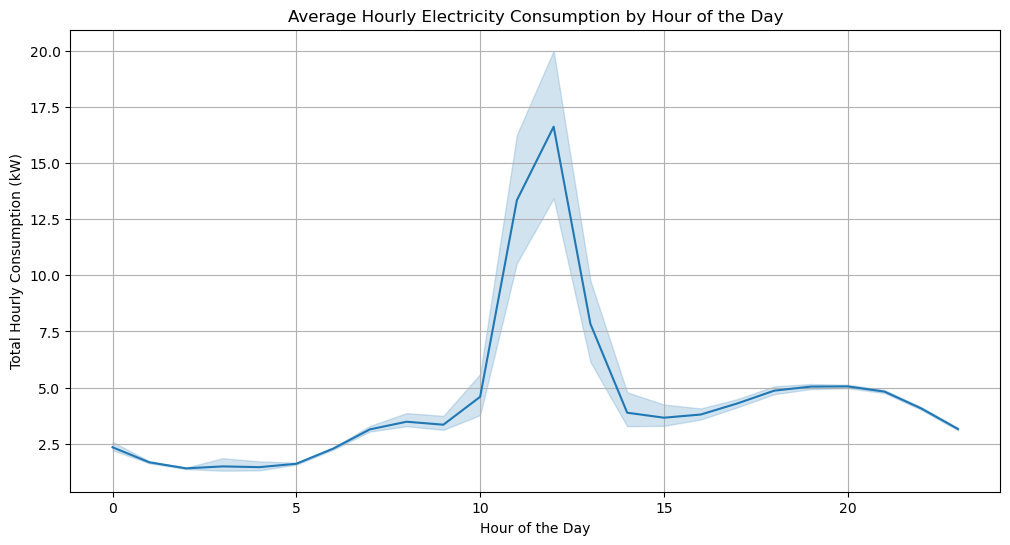

In [7]:
# Extract additional time-based features
import matplotlib.pyplot as plt
import seaborn as sns

final_df['Hour'] = final_df['Date/Time'].dt.hour
final_df['Weekday'] = final_df['Date/Time'].dt.weekday
final_df['Month'] = final_df['Date/Time'].dt.month

# Plot Total Hourly Consumption by Hour of the Day
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='Hour', y='Total_Hourly_Consumption_kW', estimator='mean')
plt.title('Average Hourly Electricity Consumption by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Hourly Consumption (kW)')
plt.grid(True)
plt.show()

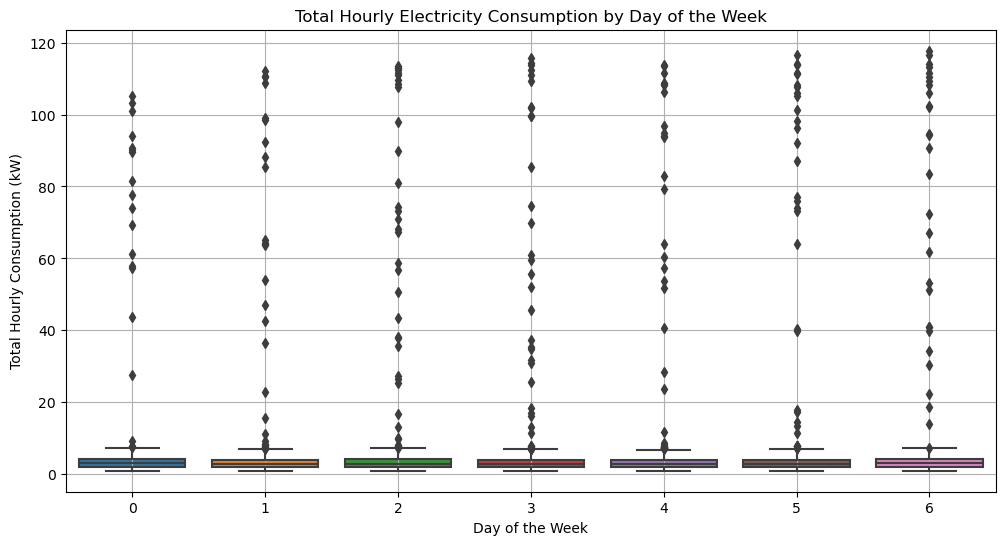

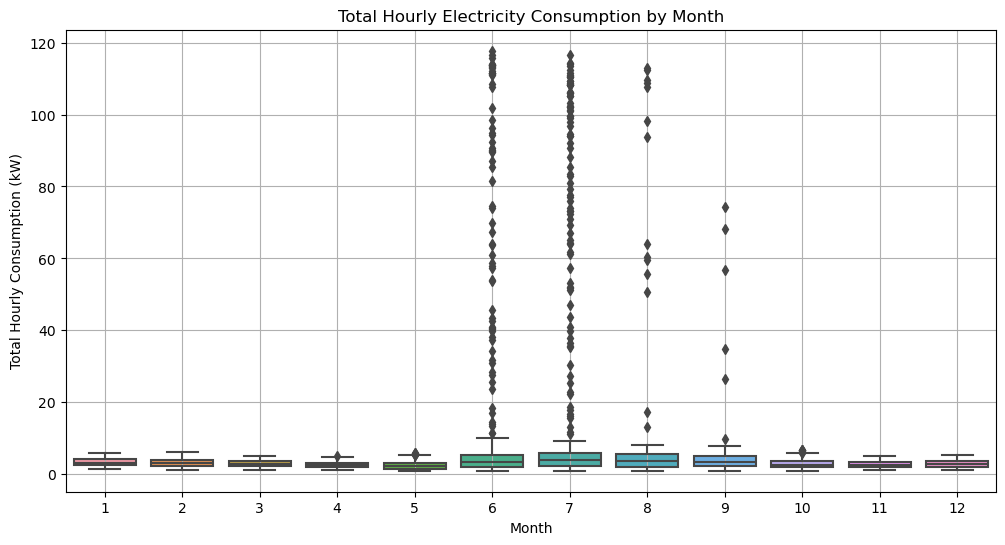

In [8]:
# Plot Total Hourly Consumption by Day of the Week
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df, x='Weekday', y='Total_Hourly_Consumption_kW')
plt.title('Total Hourly Electricity Consumption by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Hourly Consumption (kW)')
plt.grid(True)
plt.show()

# Plot Total Hourly Consumption by Month
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df, x='Month', y='Total_Hourly_Consumption_kW')
plt.title('Total Hourly Electricity Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Total Hourly Consumption (kW)')
plt.grid(True)
plt.show()

# Summarize patterns observed from the data
summary_by_hour = final_df.groupby('Hour')['Total_Hourly_Consumption_kW'].mean()
summary_by_weekday = final_df.groupby('Weekday')['Total_Hourly_Consumption_kW'].mean()
summary_by_month = final_df.groupby('Month')['Total_Hourly_Consumption_kW'].mean()

In [9]:
print("Summary by Hour of the Day:")
print(summary_by_hour)
print("\nSummary by Day of the Week:")
print(summary_by_weekday)
print("\nSummary by Month:")
print(summary_by_month)

Summary by Hour of the Day:
Hour
0      2.338525
1      1.669067
2      1.398584
3      1.486537
4      1.452910
5      1.604091
6      2.276847
7      3.136238
8      3.477386
9      3.344584
10     4.587999
11    13.352723
12    16.628693
13     7.837965
14     3.879551
15     3.657015
16     3.797821
17     4.294006
18     4.861868
19     5.043768
20     5.051758
21     4.819463
22     4.069268
23     3.151522
Name: Total_Hourly_Consumption_kW, dtype: float64

Summary by Day of the Week:
Weekday
0    4.130476
1    4.153985
2    4.693351
3    4.488714
4    4.423880
5    4.607508
6    4.780518
Name: Total_Hourly_Consumption_kW, dtype: float64

Summary by Month:
Month
1      3.332067
2      3.186052
3      2.894617
4      2.572153
5      2.504565
6      9.684801
7     11.855652
8      5.143975
9      3.821737
10     2.815600
11     2.719212
12     2.984601
Name: Total_Hourly_Consumption_kW, dtype: float64


## Hourly Pattern:
Peak Consumption: There is a clear peak in electricity consumption around 10 AM. This peak could be due to increased activity in the household or the operation of high-power appliances during this time.

Low Consumption: Electricity consumption is relatively low during the early morning hours (midnight to 6 AM) and in the late evening hours (after 8 PM). This is expected as these are typically periods of lower activity in a household.
## Weekly Pattern:
Consistent Consumption: The total hourly electricity consumption appears to be relatively consistent across different days of the week, with no significant variation. This suggests that the electricity usage pattern does not change much from weekday to weekend.

Outliers: There are several outliers indicating very high consumption values. These could be due to specific high-power activities or appliances being used sporadically throughout the week.
## Monthly Pattern:
Increased Consumption in Summer Months: There is a noticeable increase in electricity consumption during the summer months (June, July, and August). This is likely due to the use of air conditioning or other cooling systems during hotter weather.

Relatively Stable Consumption in Other Months: Apart from the summer months, electricity consumption remains relatively stable throughout the year, with no significant spikes or drops.
## Abnormalities:
Outliers: The presence of several outliers in the weekly and monthly consumption data suggests occasional spikes in electricity usage. These could be investigated further to understand their causes, such as specific high-power appliance usage or events that result in increased consumption.
## Summary:
Daily Routine Impact: Electricity consumption patterns are heavily influenced by daily routines, with clear peaks and troughs corresponding to typical household activity patterns.

Seasonal Impact: Seasonal changes, particularly in summer, significantly affect electricity consumption due to the increased use of cooling systems.

## Assignment 3

In [11]:
import pandas as pd

def load_data(filepath):
    data = pd.read_excel(filepath)
    return data

# Load the data
filepath = '/Users/macbookair/Desktop/ECESIS Investment - 2024 Summer Internship Program/Assignment 3 - timeseries_data.xlsx'
data = load_data(filepath)
data['DATETIME'] = pd.to_datetime(data['DATETIME'], format='%m/%d/%y %H:%M')
#timeseries_data.set_index('DATETIME', inplace=True)


# Display the first few rows of the dataframe to understand its structure
print(data.head())
print(data.info())

             DATETIME  HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
0 2017-01-01 01:00:00           23.3575           2155.31   
1 2017-01-01 02:00:00           21.4650           2313.81   
2 2017-01-01 03:00:00           20.7350           2587.68   
3 2017-01-01 04:00:00           20.2700           2748.65   
4 2017-01-01 05:00:00           20.1200           2757.49   

   ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  HOURENDING  MARKETDAY  \
0                          0.0    29485.791355           1 2017-01-01   
1                          0.0    28911.565913           2 2017-01-01   
2                          0.0    28238.258175           3 2017-01-01   
3                          0.0    27821.000513           4 2017-01-01   
4                          0.0    27646.942413           5 2017-01-01   

  PEAKTYPE    MONTH  YEAR  
0  OFFPEAK  JANUARY  2017  
1  OFFPEAK  JANUARY  2017  
2  OFFPEAK  JANUARY  2017  
3  OFFPEAK  JANUARY  2017  
4  OFFPEAK  JANUARY  2017  
<class 'pandas.core.frame.

In [12]:
# Replace '-' with NaN for numerical computations
data.replace('-', pd.NA, inplace=True)

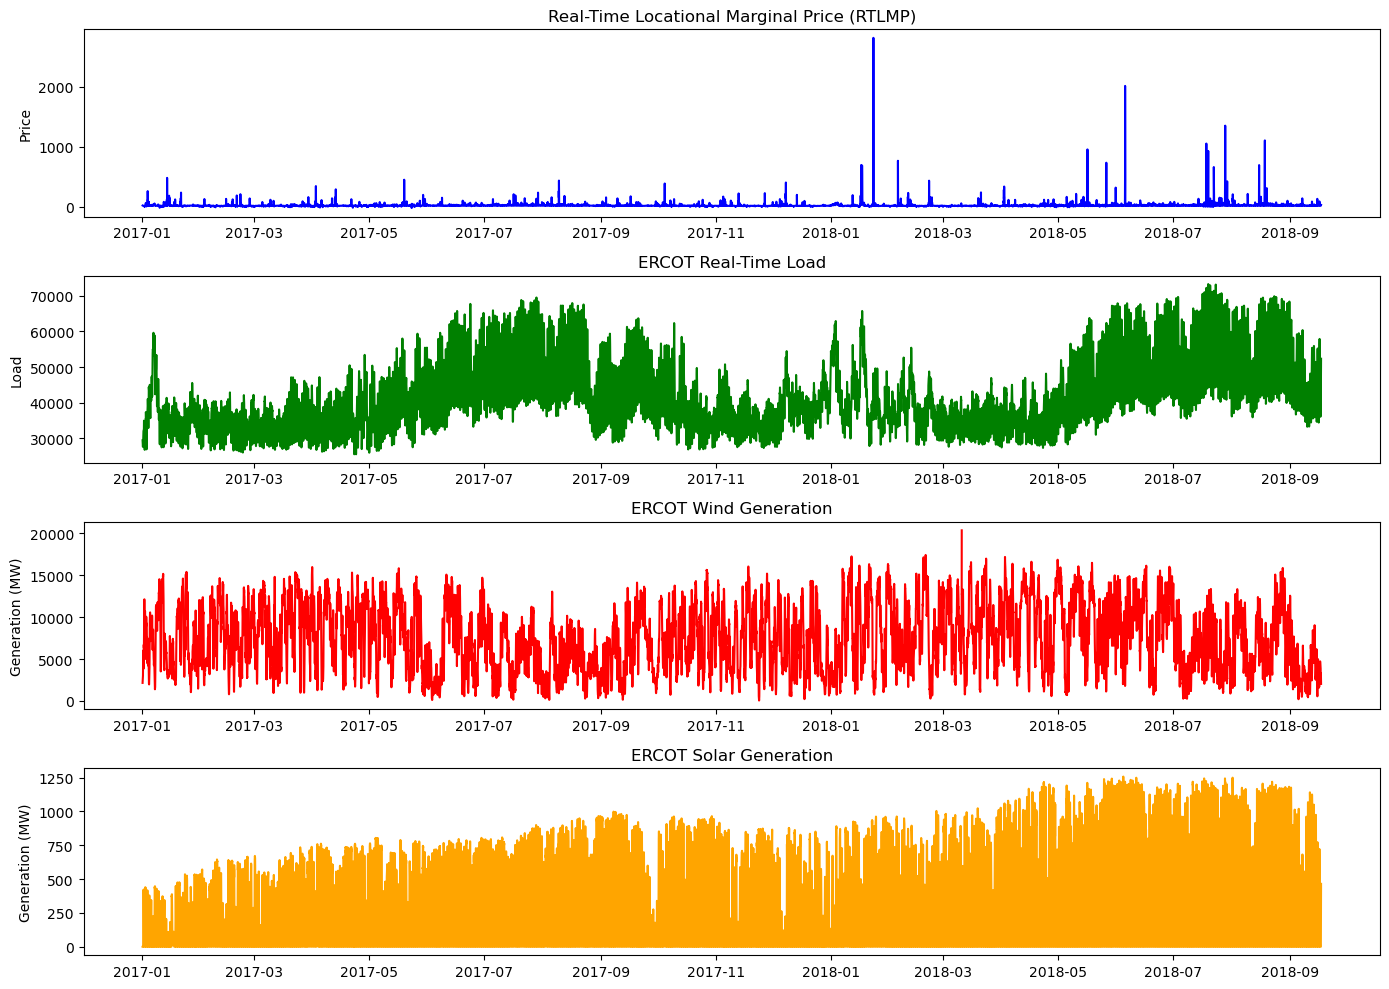

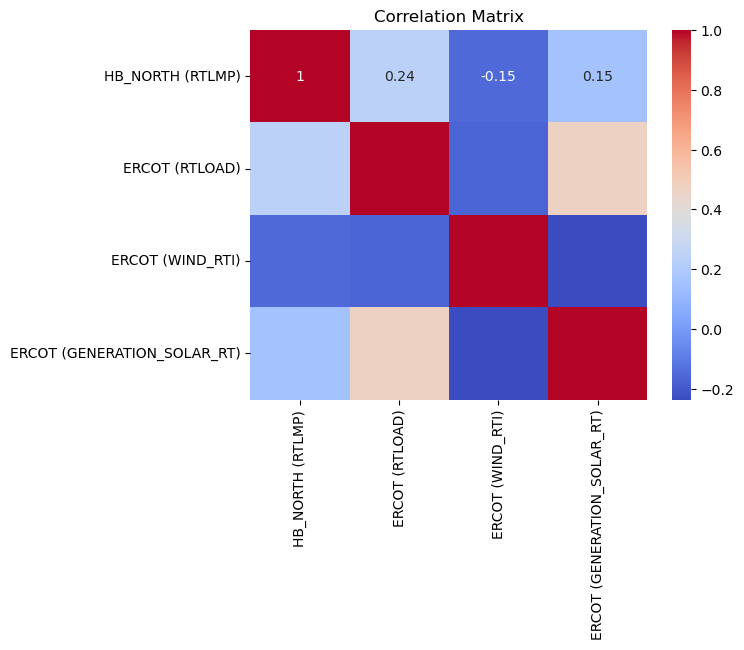

In [13]:
## Exploratory Data Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Setting plot style and size
plt.figure(figsize=(14, 10))

# Time series plot for each variable
plt.subplot(4, 1, 1)
plt.plot(data['DATETIME'], data['HB_NORTH (RTLMP)'], label='RTLMP', color='blue')
plt.title('Real-Time Locational Marginal Price (RTLMP)')
plt.ylabel('Price')

plt.subplot(4, 1, 2)
plt.plot(data['DATETIME'], data['ERCOT (RTLOAD)'], label='RTLoad', color='green')
plt.title('ERCOT Real-Time Load')
plt.ylabel('Load')

plt.subplot(4, 1, 3)
plt.plot(data['DATETIME'], data['ERCOT (WIND_RTI)'], label='Wind Generation', color='red')
plt.title('ERCOT Wind Generation')
plt.ylabel('Generation (MW)')

plt.subplot(4, 1, 4)
plt.plot(data['DATETIME'], data['ERCOT (GENERATION_SOLAR_RT)'], label='Solar Generation', color='orange')
plt.title('ERCOT Solar Generation')
plt.ylabel('Generation (MW)')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = data[['HB_NORTH (RTLMP)', 'ERCOT (RTLOAD)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [14]:
### Predictive modeling

## model 1- RandomForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Prepare data for modeling
# Creating lagged features for RTLMP to capture previous time step dependencies
data['Lag_1_RTLMP'] = data['HB_NORTH (RTLMP)'].shift(1)
data['Lag_2_RTLMP'] = data['HB_NORTH (RTLMP)'].shift(2)
data['Lag_3_RTLMP'] = data['HB_NORTH (RTLMP)'].shift(3)

# Dropping rows with NaN values that were created by lagging
model_data = data.dropna()

# Defining features and target variable
X = model_data[['ERCOT (RTLOAD)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'Lag_1_RTLMP', 'Lag_2_RTLMP', 'Lag_3_RTLMP']]
y = model_data['HB_NORTH (RTLMP)']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting the RTLMP using the test set
y_pred = rf_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

mse, mae, rmse

(656.0329407982462, 5.751083970293726, 25.613140002706544)

0
0


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


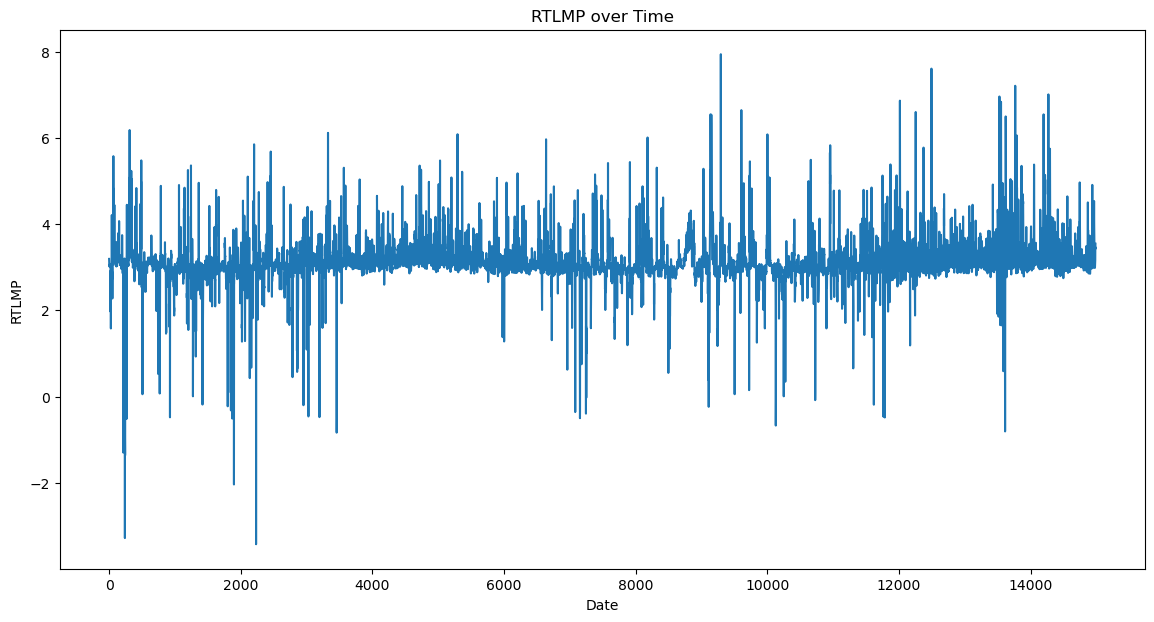

In [15]:
## ## model with log transformation & SARIMAX
import numpy as np
print(data['HB_NORTH (RTLMP)'].isnull().sum())
data['Log_RTLMP'] = np.log1p(data['HB_NORTH (RTLMP)'])
data['Log_RTLMP'].fillna(data['Log_RTLMP'].median(),inplace=True)
print(data['Log_RTLMP'].isnull().sum())


# Plotting RTLMP over time
plt.figure(figsize=(14, 7))
plt.plot(data['Log_RTLMP'])
plt.title('RTLMP over Time')
plt.xlabel('Date')
plt.ylabel('RTLMP')
plt.show()

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Split data into features and target
data.fillna(method='ffill', inplace=True)

X = data[['ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']]
y = data['Log_RTLMP']

/var/folders/3r/7cf0xpss5jb7pyzjvfv1ww000000gn/T/ipykernel_92955/2882879245.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [17]:

from statsmodels.tsa.stattools import adfuller

# Check for stationarity
result = adfuller(y)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -13.335807619248172
p-value: 6.055709245785024e-25


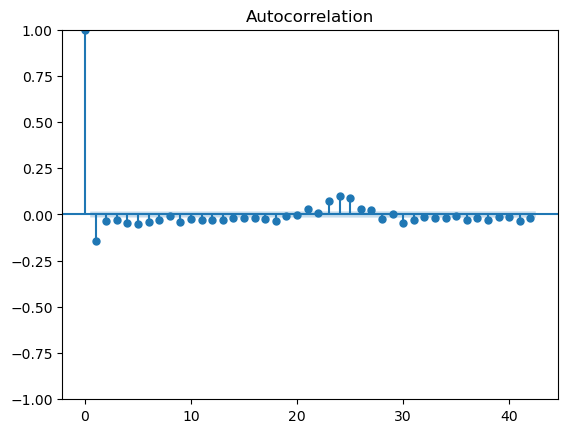

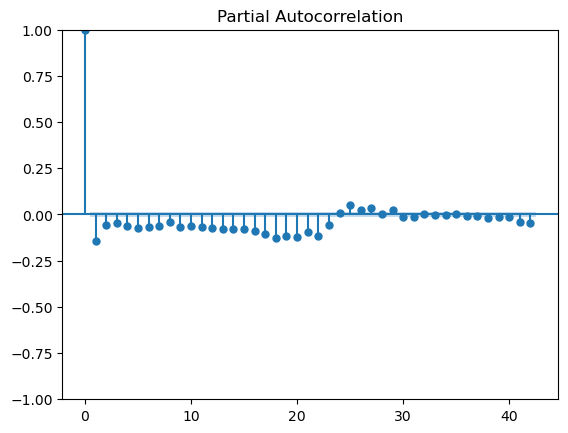

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Determine d and seasonal D
d = 1 if result[1] > 0.05 else 0  # Differencing order, simple condition

# ACF and PACF plots to help determine p, q, P, Q
plot_acf(y.diff().dropna())
plot_pacf(y.diff().dropna())
plt.show()

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(y,
                order=(1, d, 1),              # p, d, q
                seasonal_order=(1, 1, 1, 24)) # P, D, Q, S (assuming daily seasonality in hourly data)
results = model.fit(disp=False)

# Summarize model
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Log_RTLMP   No. Observations:                14987
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood               -3186.385
Date:                            Thu, 23 May 2024   AIC                           6382.770
Time:                                    18:20:07   BIC                           6420.837
Sample:                                         0   HQIC                          6395.402
                                          - 14987                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.003    247.196      0.000       0.754       0.766
ma.L1         -0.1025      0.004   

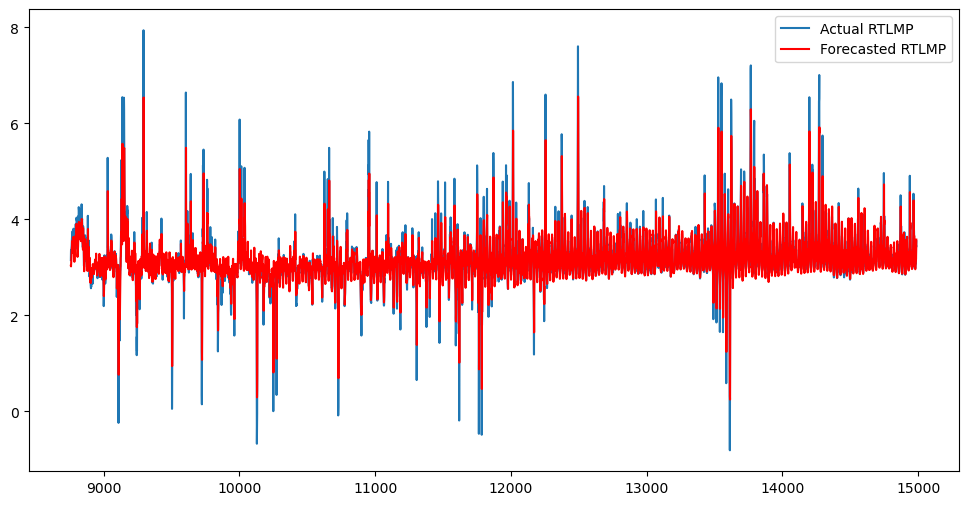

Mean Squared Error: 0.07891038634781763


In [20]:
# Train-test split
split_date = '2018-01-01'
train = data.loc[data['DATETIME'] < split_date]
test = data.loc[data['DATETIME'] >= split_date]
#backtesting 
forecast3=results.predict(start=8759, end=14986)

# Plot the forecast against actual
plt.figure(figsize=(12, 6))
plt.plot(test['Log_RTLMP'], label='Actual RTLMP')
plt.plot(forecast3, label='Forecasted RTLMP', color='r')
plt.legend()
plt.show()

# Evaluation metrics
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['Log_RTLMP'], forecast3)
print(f'Mean Squared Error: {mse}')

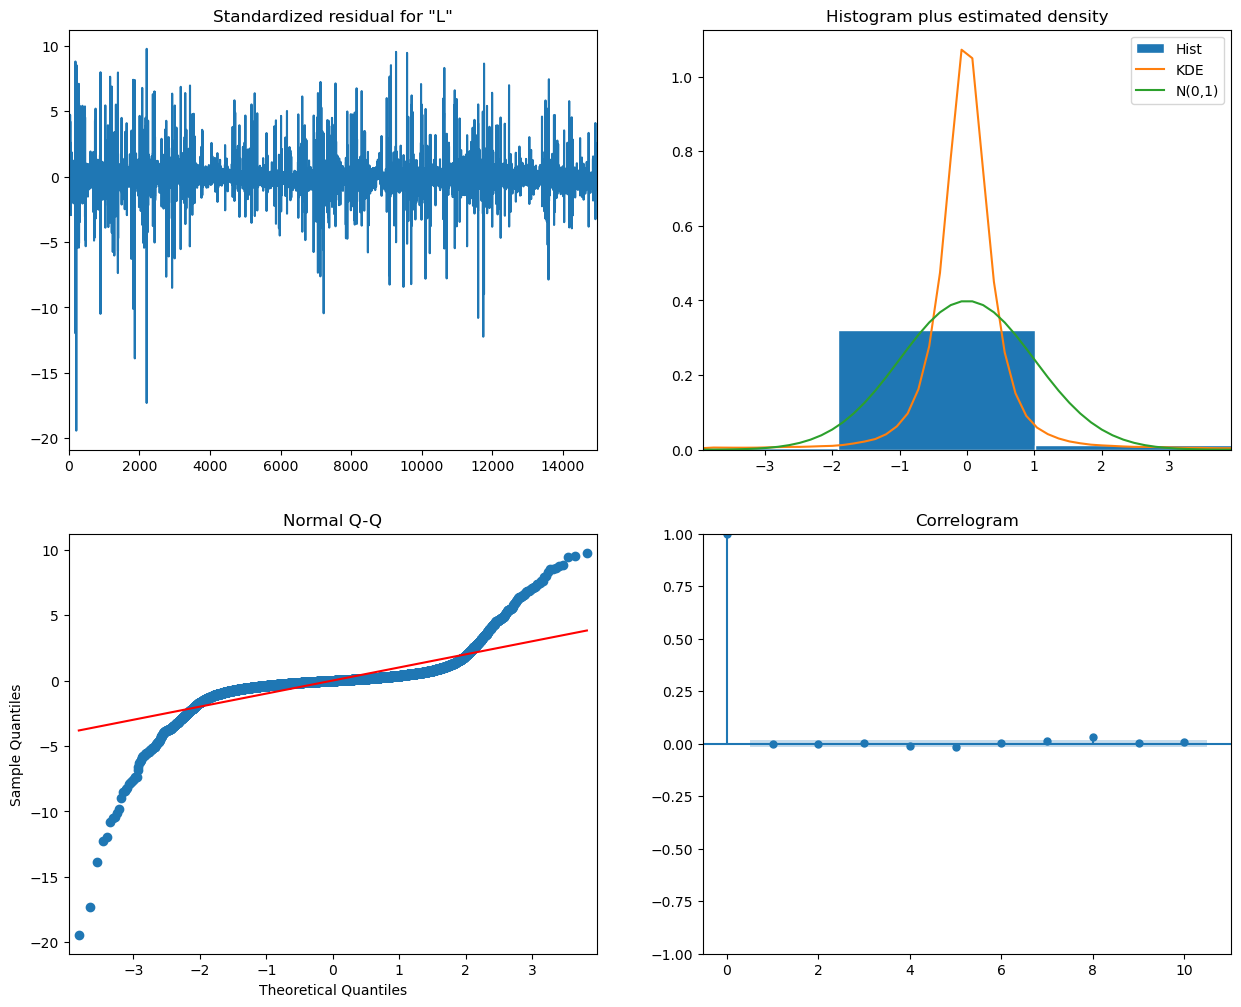

In [21]:
# Diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [22]:
# Forecast
forecast_log = results.forecast(steps=24)  # Forecasting next 24 hours
forecast = np.exp(forecast_log)
print(forecast)

14987    37.339855
14988    40.950434
14989    48.281921
14990    51.746677
14991    48.335381
14992    39.068655
14993    32.786065
14994    32.072933
14995    29.958464
14996    25.815352
14997    22.703281
14998    21.225046
14999    20.435204
15000    19.590261
15001    19.160322
15002    18.722328
15003    18.763622
15004    19.471620
15005    20.626743
15006    20.814939
15007    21.996210
15008    23.263074
15009    25.896701
15010    31.250219
Name: predicted_mean, dtype: float64


In [24]:
print('done')

done
